# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:22:49.616066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:22:49.616116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:22:49.617609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-8, who has ID: AC5GLGVJXDEFV

In [2]:
parameters = {}

user = "users-8"
user_id = "AC5GLGVJXDEFV"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A26PVNJI45T7U6,B000068GQ6,B00006IX5A,B000K8T6ZW
1,A2YX48UA5VB0EE,B000068GQ6,B0072K0X7G,B00BSYR7K8
2,A1X3RECS1XZ8TX,B000068GQ6,B00EI673B6,B00YND4R4K
3,A15RJPWC0GZLNI,B000068GQ6,B00LJ313EE,B018S3AOLU
4,A27WV4V47468DU,B000068GQ6,B000OQTMI6,B000F5CDJG
...,...,...,...,...
27031,A1VM76V1A8FJG2,B012D2PT76,B00L813DSG,B01D8VQ3ZS
27032,A13B1SWV5YLO4Y,B012D2PT76,B01C4O9VFY,B00PXM1ONW
27033,A1OU0E7J5C3164,B013OASU6S,B001HT0LQG,B00O6A9PKQ
27034,A31364GZQGNWD9,B013OASU6S,B01ALNQ6CQ,B007ZOC11K


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 27036
Number of sequences and targets after removal: 26525


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            AC5GLGVJXDEFV
productID                B00ZJ5BJ74
purchased_before_1       B00AV5KQZ8
purchased_before_2       B012D2PT76
Name: 180, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 26524
Number of sequences and targets after dropping duplicates: 25292


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 101
Number of unique product IDs in sequences: 15636


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B00006IX5A', 'B000K8T6ZW'],
        ['B0072K0X7G', 'B00BSYR7K8'],
        ['B00EI673B6', 'B00YND4R4K'],
        ['B00LJ313EE', 'B018S3AOLU'],
        ['B000OQTMI6', 'B000F5CDJG'],
        ['B0002AR19Q', 'B0026P6T6G'],
        ['B00HS9BD6Q', 'B00I8VZTZO'],
        ['B0009YYK0I', 'B00RM8AYSQ'],
        ['B00ANZUG92', 'B00ANZUFHU'],
        ['B000MD57ZI', 'B000084E7Y']], dtype=object),
 array(['B000068GQ6', 'B000068GQ6', 'B000068GQ6', 'B000068GQ6',
        'B000068GQ6', 'B000068GQ6', 'B000068GQ6', 'B000068GQ6',
        'B0012KB4NO', 'B000068GQ6'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[208, 13833],
        [54166, 70180],
        [78812, 118309],
        [97248, 130619],
        [15567, 11212],
        [2455, 29208],
        [86784, 88184],
        [9620, 108453],
        [66083, 66080],
        [14345, 255]], dtype=object),
 array([188, 188, 188, 188, 188, 188, 188, 188, 19864, 188], dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 20215
Number of validation sequences: 2537
Number of test sequences: 2540

Number of train targets: 20215
Number of validation targets: 2537
Number of test targets: 2540

Number of classes (unique product IDs) in the train targets: 97
Number of classes in the validation targets: 101
Number of classes in the test targets: 101


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([5399, 49602], dtype=object),
 array([25837, 40758], dtype=object),
 array([28710, 5441], dtype=object),
 array([78812, 118309], dtype=object),
 array([73487, 114664], dtype=object),
 array([41398, 21766], dtype=object),
 array([14345, 255], dtype=object),
 array([74911, 102985], dtype=object),
 array([15567, 11212], dtype=object),
 array([78869, 80953], dtype=object)]

In [19]:
y_train[:10]

[188, 188, 188, 188, 188, 188, 188, 188, 188, 188]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/632 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0707 - f1_score: 0.0489 - f1_score_at_k: 0.0998 - hit_rate_at_k: 0.2549 - loss: 11.8386 - ndcg_at_k: 0.0554                     

I0000 00:00:1714591384.475038    2376 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


632/632 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1129 - f1_score: 0.0505 - f1_score_at_k: 0.0788 - hit_rate_at_k: 0.3123 - loss: 7.9620 - ndcg_at_k: 0.0732 - val_accuracy: 0.0709 - val_f1_score: 0.0767 - val_f1_score_at_k: 0.3121 - val_hit_rate_at_k: 0.2944 - val_loss: 3.9402 - val_ndcg_at_k: 0.0624
Epoch 2/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1445 - f1_score: 0.0758 - f1_score_at_k: 0.1130 - hit_rate_at_k: 0.3564 - loss: 3.6281 - ndcg_at_k: 0.0862 - val_accuracy: 0.1041 - val_f1_score: 0.1386 - val_f1_score_at_k: 0.3588 - val_hit_rate_at_k: 0.3326 - val_loss: 3.7952 - val_ndcg_at_k: 0.0748
Epoch 3/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1655 - f1_score: 0.0993 - f1_score_at_k: 0.1612 - hit_rate_at_k: 0.4186 - loss: 3.4112 - ndcg_at_k: 0.0996 - val_accuracy: 0.1281 - val_f1_score: 0.1717 - val_f1_score_at_k: 0.3857 - val_hit_rate_at_k: 0.3433 - val_loss: 3.7510 - val_ndcg_at_k: 0.0810
Epoch 4/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - a

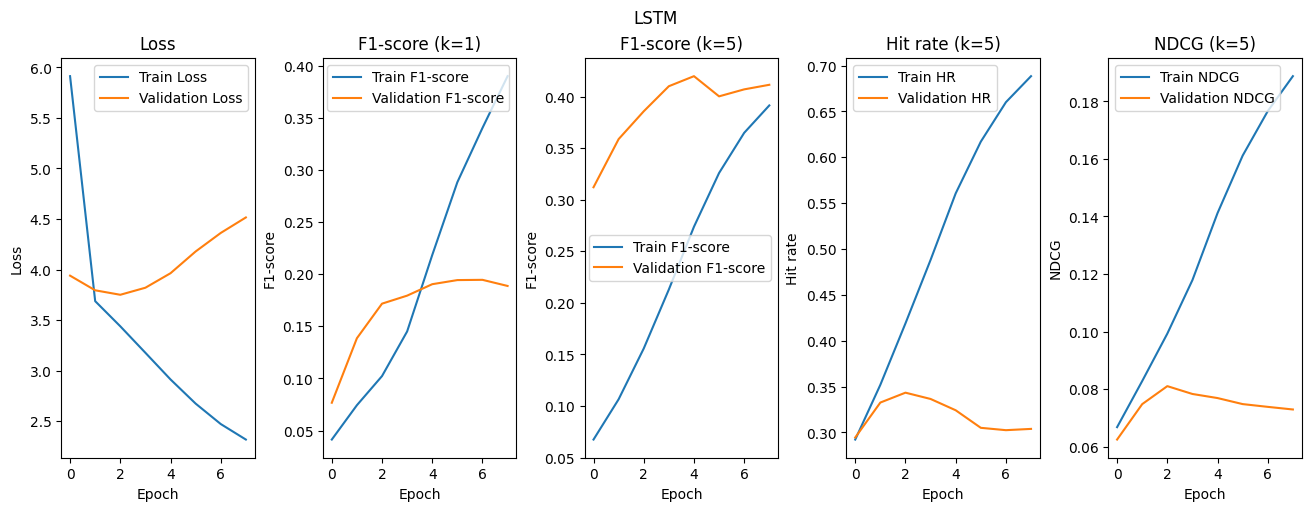

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1001 - f1_score: 0.1536 - f1_score_at_k: 0.4026 - hit_rate_at_k: 0.2950 - loss: 4.5656 - ndcg_at_k: 0.0671
Test loss: 4.5072
Test accuracy: 0.128
Test F1@1: 0.1921
Test F1@5: 0.4113
Test HR@5: 0.3096
Test NDCG@5: 0.0747


In [32]:
parameters

{'user': 'users-8',
 'user_id': 'AC5GLGVJXDEFV',
 'number_of_sequences_and_targets_before_removal': 27036,
 'number_of_sequences_and_targets_after_removal': 26525,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 25292,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 15636,
 'number_of_sequences_and_targets_train': 20215,
 'number_of_sequences_and_targets_validation': 2537,
 'number_of_sequences_and_targets_test': 2540,
 'number_of_unique_products_in_targets_train': 97,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.507211685180664,
 'model_lstm_test_accuracy': 0.128,
 'model_lstm_test_f1_score_k_1': 0.1921,
 'model_lstm_test_f1_score_k_5': 0.4113,
 'model_lstm_test_hr': 0.3096,
 'model_lstm_test_ndcg': 0.0747}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.1111 - f1_score: 0.0418 - f1_score_at_k: 0.0792 - hit_rate_at_k: 0.3169 - loss: 7.5898 - ndcg_at_k: 0.0735 - val_accuracy: 0.0773 - val_f1_score: 0.0859 - val_f1_score_at_k: 0.2971 - val_hit_rate_at_k: 0.2784 - val_loss: 3.9431 - val_ndcg_at_k: 0.0593
Epoch 2/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1408 - f1_score: 0.0835 - f1_score_at_k: 0.1221 - hit_rate_at_k: 0.3661 - loss: 3.5833 - ndcg_at_k: 0.0870 - val_accuracy: 0.1368 - val_f1_score: 0.1831 - val_f1_score_at_k: 0.3911 - val_hit_rate_at_k: 0.3433 - val_loss: 3.7600 - val_ndcg_at_k: 0.0818
Epoch 3/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1885 - f1_score: 0.1333 - f1_score_at_k: 0.1996 - hit_rate_at_k: 0.4631 - loss: 3.2546 - ndcg_at_k: 0.1114 - val_accuracy: 0.1281 - val_f1_score: 0.1854 - val_f1_score_at_k: 0.4093 - val_hit_rate_at_k: 0.3361 - val_loss: 3.7710 - val_ndcg_at_k: 0.0791
Epoch 4/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 7

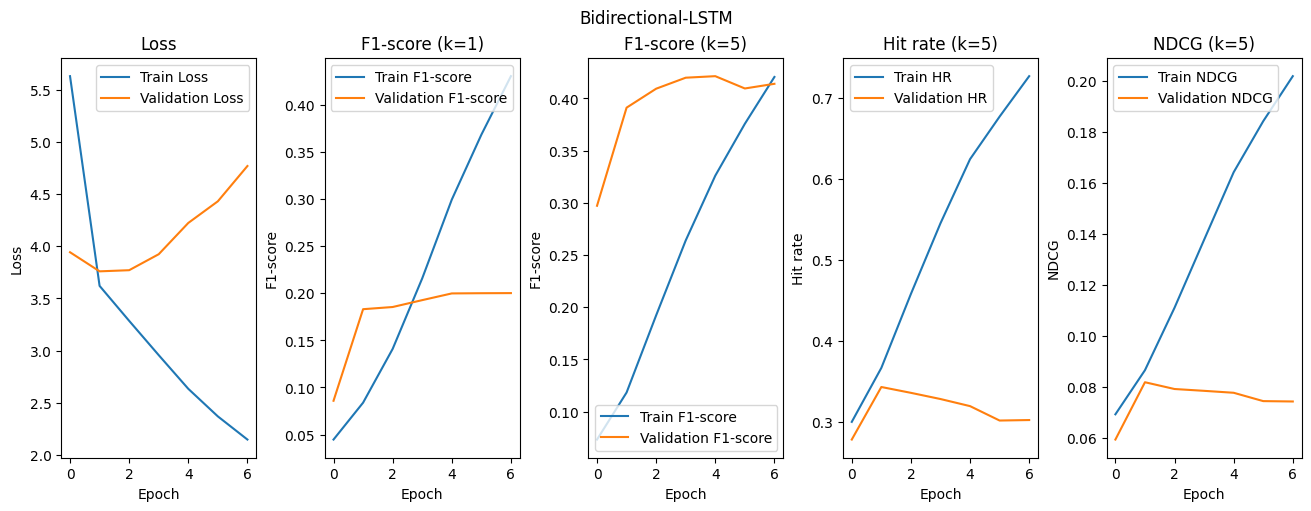

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1007 - f1_score: 0.1547 - f1_score_at_k: 0.4071 - hit_rate_at_k: 0.2930 - loss: 4.8225 - ndcg_at_k: 0.0671
Test loss: 4.76
Test accuracy: 0.1283
Test F1@1: 0.1947
Test F1@5: 0.4122
Test HR@5: 0.3039
Test NDCG@5: 0.0741


In [37]:
parameters

{'user': 'users-8',
 'user_id': 'AC5GLGVJXDEFV',
 'number_of_sequences_and_targets_before_removal': 27036,
 'number_of_sequences_and_targets_after_removal': 26525,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 25292,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 15636,
 'number_of_sequences_and_targets_train': 20215,
 'number_of_sequences_and_targets_validation': 2537,
 'number_of_sequences_and_targets_test': 2540,
 'number_of_unique_products_in_targets_train': 97,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.507211685180664,
 'model_lstm_test_accuracy': 0.128,
 'model_lstm_test_f1_score_k_1': 0.1921,
 'model_lstm_test_f1_score_k_5': 0.4113,
 'model_lstm_test_hr': 0.3096,
 'model_lstm_test_ndcg': 0.0747,
 'model_bi_lstm_test_loss': 4.759954929351807,
 'model_bi_lstm_test_accuracy': 0.1283,
 'model_bi_lstm_test_f1_score_k_1': 0.194

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.1097 - f1_score: 0.0447 - f1_score_at_k: 0.0811 - hit_rate_at_k: 0.3228 - loss: 7.8927 - ndcg_at_k: 0.0744 - val_accuracy: 0.0824 - val_f1_score: 0.0998 - val_f1_score_at_k: 0.3108 - val_hit_rate_at_k: 0.2943 - val_loss: 3.9224 - val_ndcg_at_k: 0.0628
Epoch 2/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1370 - f1_score: 0.0694 - f1_score_at_k: 0.1097 - hit_rate_at_k: 0.3540 - loss: 3.6362 - ndcg_at_k: 0.0845 - val_accuracy: 0.1115 - val_f1_score: 0.1477 - val_f1_score_at_k: 0.3628 - val_hit_rate_at_k: 0.3349 - val_loss: 3.8208 - val_ndcg_at_k: 0.0761
Epoch 3/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1588 - f1_score: 0.1038 - f1_score_at_k: 0.1520 - hit_rate_at_k: 0.4060 - loss: 3.4518 - ndcg_at_k: 0.0970 - val_accuracy: 0.1250 - val_f1_score: 0.1708 - val_f1_score_at_k: 0.4097 - val_hit_rate_at_k: 0.3548 - val_loss: 3.7533 - val_ndcg_at_k: 0.0819
Epoch 4/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 6

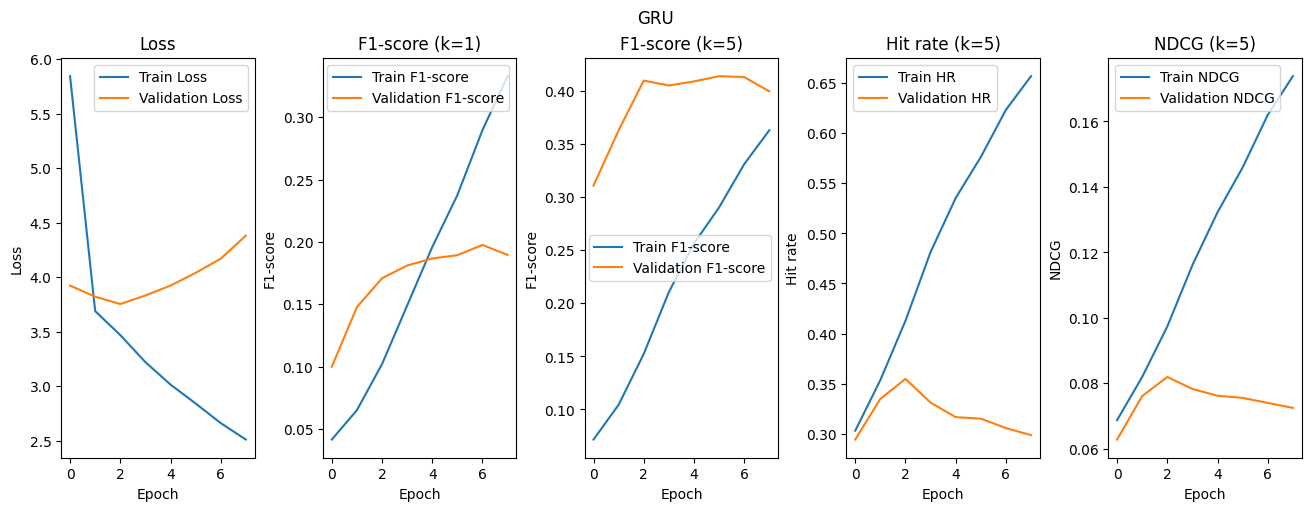

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0989 - f1_score: 0.1529 - f1_score_at_k: 0.3950 - hit_rate_at_k: 0.2886 - loss: 4.4367 - ndcg_at_k: 0.0661
Test loss: 4.3499
Test accuracy: 0.1213
Test F1@1: 0.1843
Test F1@5: 0.4057
Test HR@5: 0.3048
Test NDCG@5: 0.0731


In [42]:
parameters

{'user': 'users-8',
 'user_id': 'AC5GLGVJXDEFV',
 'number_of_sequences_and_targets_before_removal': 27036,
 'number_of_sequences_and_targets_after_removal': 26525,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 25292,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 15636,
 'number_of_sequences_and_targets_train': 20215,
 'number_of_sequences_and_targets_validation': 2537,
 'number_of_sequences_and_targets_test': 2540,
 'number_of_unique_products_in_targets_train': 97,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.507211685180664,
 'model_lstm_test_accuracy': 0.128,
 'model_lstm_test_f1_score_k_1': 0.1921,
 'model_lstm_test_f1_score_k_5': 0.4113,
 'model_lstm_test_hr': 0.3096,
 'model_lstm_test_ndcg': 0.0747,
 'model_bi_lstm_test_loss': 4.759954929351807,
 'model_bi_lstm_test_accuracy': 0.1283,
 'model_bi_lstm_test_f1_score_k_1': 0.194

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.0592 - f1_score: 0.0371 - f1_score_at_k: 0.0743 - hit_rate_at_k: 0.1784 - loss: 9.6661 - ndcg_at_k: 0.0404 - val_accuracy: 0.0922 - val_f1_score: 0.1260 - val_f1_score_at_k: 0.3009 - val_hit_rate_at_k: 0.2926 - val_loss: 3.9594 - val_ndcg_at_k: 0.0649
Epoch 2/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1357 - f1_score: 0.0733 - f1_score_at_k: 0.1101 - hit_rate_at_k: 0.3416 - loss: 3.7174 - ndcg_at_k: 0.0819 - val_accuracy: 0.0962 - val_f1_score: 0.1346 - val_f1_score_at_k: 0.3020 - val_hit_rate_at_k: 0.2888 - val_loss: 3.9001 - val_ndcg_at_k: 0.0667
Epoch 3/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1322 - f1_score: 0.0763 - f1_score_at_k: 0.1181 - hit_rate_at_k: 0.3379 - loss: 3.6739 - ndcg_at_k: 0.0810 - val_accuracy: 0.1159 - val_f1_score: 0.1511 - val_f1_score_at_k: 0.3130 - val_hit_rate_at_k: 0.2931 - val_loss: 3.8694 - val_ndcg_at_k: 0.0707
Epoch 4/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 7

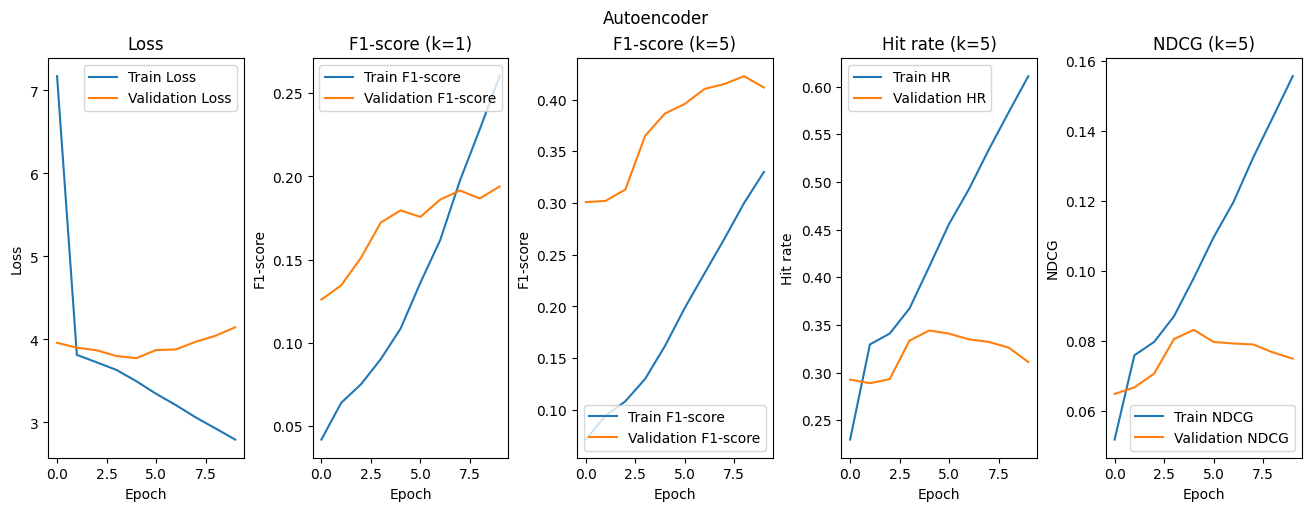

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0956 - f1_score: 0.1492 - f1_score_at_k: 0.4064 - hit_rate_at_k: 0.3071 - loss: 4.1876 - ndcg_at_k: 0.0680
Test loss: 4.1457
Test accuracy: 0.1177
Test F1@1: 0.1777
Test F1@5: 0.4
Test HR@5: 0.304
Test NDCG@5: 0.0719


In [47]:
parameters

{'user': 'users-8',
 'user_id': 'AC5GLGVJXDEFV',
 'number_of_sequences_and_targets_before_removal': 27036,
 'number_of_sequences_and_targets_after_removal': 26525,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 25292,
 'num_unique_product_ids_in_targets': 101,
 'num_unique_product_ids_in_sequences': 15636,
 'number_of_sequences_and_targets_train': 20215,
 'number_of_sequences_and_targets_validation': 2537,
 'number_of_sequences_and_targets_test': 2540,
 'number_of_unique_products_in_targets_train': 97,
 'number_of_unique_products_in_targets_validation': 101,
 'number_of_unique_products_in_targets_test': 101,
 'model_lstm_test_loss': 4.507211685180664,
 'model_lstm_test_accuracy': 0.128,
 'model_lstm_test_f1_score_k_1': 0.1921,
 'model_lstm_test_f1_score_k_5': 0.4113,
 'model_lstm_test_hr': 0.3096,
 'model_lstm_test_ndcg': 0.0747,
 'model_bi_lstm_test_loss': 4.759954929351807,
 'model_bi_lstm_test_accuracy': 0.1283,
 'model_bi_lstm_test_f1_score_k_1': 0.194

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'AC5GLGVJXDEFV', 'sequence': [66862, 121835], 'target': 119134}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 1.0
NDCG@5: 0.3391602039337158
-------------
HT@10: 1.0
NDCG@10: 0.22009176015853882
-------------
HT@20: 1.0
NDCG@20: 0.14204004406929016
-------------
HT@50: 1.0
NDCG@50: 0.07753300666809082
-------------
HT@100: 1.0
NDCG@100: 0.047758519649505615
-------------
HT@200: 1.0
NDCG@200: 0.02872072346508503
-------------
HT@300: 1.0
NDCG@300: 0.021106459200382233
-------------
HT@400: 1.0
NDCG@400: 0.01688845455646515
-------------
HT@500: 1.0
NDCG@500: 0.014172977767884731
-------------
